# Langgraph-Supervisor Cookbook

This notebook serves as a cookbook for using the Langgraph-Supervisor. It provides step-by-step instructions and examples to help you understand and utilize the capabilities of Langgraph-Supervisor effectively.


## Section 1: Setup and Configuration


In [1]:
from dotenv import load_dotenv

load_dotenv()

True

## Section 2: Basic Usage

This section demonstrates the basic usage of Langgraph-Supervisor, including how to invoke its primary functions.

**Agents Overview:**
- **Math Expert**: Handles all mathematical calculations using provided tools.
- **Research Expert**: Handles research and web search queries, but does not perform math.
- **Supervisor**: Manages the workflow, deciding which agent should handle each part of a user query.

In [2]:
from langchain_google_genai import ChatGoogleGenerativeAI
from langgraph_supervisor import create_supervisor
from langgraph.prebuilt import create_react_agent

model = ChatGoogleGenerativeAI(model="gemini-2.0-flash")

# Create specialized agents

def add(a: float, b: float) -> float:
    """Add two numbers."""
    return a + b

def multiply(a: float, b: float) -> float:
    """Multiply two numbers."""
    return a * b

def web_search(query: str) -> str:
    """Search the web for information."""
    return (
        "Here are the headcounts for each of the FAANG companies in 2024:\n"
        "1. **Facebook (Meta)**: 67,317 employees.\n"
        "2. **Apple**: 164,000 employees.\n"
        "3. **Amazon**: 1,551,000 employees.\n"
        "4. **Netflix**: 14,000 employees.\n"
        "5. **Google (Alphabet)**: 181,269 employees."
    )

math_agent = create_react_agent(
    model=model,
    tools=[add, multiply],
    name="math_expert",
    prompt="You are a math expert. Always use one tool at a time."
)

research_agent = create_react_agent(
    model=model,
    tools=[web_search],
    name="research_expert",
    prompt="You are a world class researcher with access to web search. Do not do any math."
)

# Create supervisor workflow
workflow = create_supervisor(
    [research_agent, math_agent],
    model=model,
    prompt=(
        "You are a team supervisor managing a research expert and a math expert. "
        "For current events, use research_agent. "
        "For math problems, use math_agent."
    )
)

# Compile and run
app = workflow.compile()

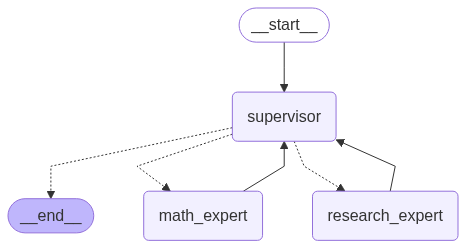

In [3]:
from IPython.display import Image, display

display(Image(app.get_graph().draw_mermaid_png()))

In [4]:
result = app.invoke({
    "messages": [
        {
            "role": "user",
            "content": "what's the combined headcount of the FAANG companies in 2024? Consult your research expert"
        }
    ]
})

for m in result["messages"]:
    m.pretty_print()

================================ Human Message =================================

what's the combined headcount of the FAANG companies in 2024? Consult your research expert
================================== Ai Message ==================================
Name: supervisor
Tool Calls:
  transfer_to_research_expert (4505fc40-a6d3-4ca5-ba18-048e6441b56f)
 Call ID: 4505fc40-a6d3-4ca5-ba18-048e6441b56f
  Args:
================================= Tool Message =================================
Name: transfer_to_research_expert

Successfully transferred to research_expert
================================== Ai Message ==================================
Name: research_expert

Okay, I will consult my research expert to find the combined headcount of the FAANG companies in 2024.
================================== Ai Message ==================================
Name: research_expert

Transferring back to supervisor
Tool Calls:
  transfer_back_to_supervisor (7d0a954c-128c-4cc8-940a-741025aa3485)
 Call ID:

## Section 3: Advanced Features

Explore the advanced features of Langgraph-Supervisor in this section, showcasing more complex use cases and configurations.

**Agents in the Customer Support Swarm:**
- **Intent Classifier**: Categorizes incoming customer queries.
- **FAQ Responder**: Answers routine questions using a knowledge base.
- **Troubleshooter**: Guides users through diagnostic steps for technical issues.
- **Escalation Gatekeeper**: Decides if an issue should be escalated to a human agent.
- **Sentiment Tracker**: Analyzes customer sentiment and churn risk.

**Memory Components:**
- **InMemorySaver**: Provides short-term memory for the workflow, storing recent conversation state.
- **InMemoryStore**: Provides long-term memory, allowing the workflow to persist and retrieve information across sessions.


In [18]:
from langchain_google_genai import ChatGoogleGenerativeAI
from langgraph.prebuilt import create_react_agent
from langgraph_supervisor import create_supervisor
from langgraph_supervisor.handoff import create_forward_message_tool

from langgraph.checkpoint.memory import InMemorySaver
from langgraph.store.memory import InMemoryStore

model = ChatGoogleGenerativeAI(model="gemini-2.0-flash")

forwarding_tool = create_forward_message_tool("supervisor") # The argument is the name to assign to the resulting forwarded message

# --- Tool Definitions ---
# Note: These are stubs. For production, you'll need to implement their actual logic.

def search_faq(query: str) -> str:
    """
    Searches the company's FAQ knowledge base for an answer to the given query.
    Returns the most relevant FAQ entry or 'No relevant FAQ found.'.
    
    For production: Implement logic to query your FAQ database/vector store.
    """
    print(f"Executing search_faq with query: {query}")
    # Placeholder implementation
    if "password reset" in query.lower():
        return "To reset your password, go to Account > Settings > Reset Password."
    elif "refund policy" in query.lower():
        return "Our refund policy allows for refunds within 30 days of purchase. Please visit our website for more details."
    return "No relevant FAQ found for your query."

def get_diagnostic_steps(issue_description: str, product_name: str | None = None) -> str:
    """
    Fetches step-by-step diagnostic procedures for a given issue description and optional product name.
    Returns a list of steps or 'No diagnostic guide found.'.

    For production: Implement logic to retrieve guides from a knowledge base or CMS.
    """
    print(f"Executing get_diagnostic_steps for issue: {issue_description}, product: {product_name}")
    # Placeholder implementation
    if "cannot connect to internet" in issue_description.lower():
        return "1. Check your modem and router lights. 2. Restart your modem and router. 3. Ensure your network cable is securely connected. 4. Try connecting with a different device."
    return f"No specific diagnostic guide found for '{issue_description}'."

def check_system_status(service_name: str) -> str:
    """
    Checks the current operational status of a specific company service 
    (e.g., 'website', 'login_api', 'payment_gateway').
    Returns 'Operational', 'Degraded', or 'Outage'.

    For production: Implement logic to query your actual system monitoring tools.
    """
    print(f"Executing check_system_status for service: {service_name}")
    # Placeholder implementation
    if service_name.lower() in ["website", "login_api"]:
        return "Operational"
    elif service_name.lower() == "payment_gateway":
        return "Degraded" # Example of a non-operational status
    return "Status unknown for this service."

def create_human_escalation_ticket(
    customer_id: str, 
    issue_summary: str, 
    reason_for_escalation: str, 
) -> str:
    """
    Creates a ticket in the human support system (e.g., Zendesk, Jira) with all relevant details.
    Returns a ticket ID like "TICKET-12345" or an error message.

    For production: Implement integration with your ticketing system API.
    """
    print(f"Executing create_human_escalation_ticket for customer: {customer_id}, issue: {issue_summary}")
    # Placeholder implementation
    import random
    ticket_id = f"TICKET-{random.randint(10000, 99999)}"
    print(f"Escalation ticket {ticket_id} created. Details: {issue_summary}, Reason: {reason_for_escalation}")
    return ticket_id

# --- Agent Definitions ---

# 1. Intent Classifier Agent
intent_classifier_agent = create_react_agent(
    model=model,
    tools=[], # No external tools, relies on LLM classification
    name="intent_classifier",
    prompt=(
        "You are an expert Intent Classifier for customer support. Your primary role is to accurately categorize incoming customer queries. "
        "Based on the user's message, classify the intent into one of the following categories: "
        "[Billing Inquiry, Technical Issue, Product Question, Account Management, Order Status, General Feedback, Bug Report, Other]. "
        "Your output should ONLY be the category name. Do not add any other text or explanation."
        "Example: If the user says 'I can't log in', you should output: Technical Issue"
    )
).with_config(tags=["skip_stream"])

# 2. FAQ Responder Agent
faq_responder_agent = create_react_agent(
    model=model,
    tools=[search_faq],
    name="faq_responder",
    prompt=(
        "You are an FAQ Responder. Your goal is to answer routine customer issues instantly using the 'search_faq' tool. "
        "Carefully analyze the user's query and use the search_faq tool to find a relevant answer from the knowledge base. "
        "If a relevant FAQ is found, provide the answer clearly and concisely. "
        "If the query cannot be answered by an FAQ or if the tool returns 'No relevant FAQ found.', "
        "clearly state that you couldn't find an answer in the FAQ and that the issue might require further assistance."
    )
).with_config(tags=["skip_stream"])

# 3. Troubleshooter Agent
troubleshooter_agent = create_react_agent(
    model=model,
    tools=[get_diagnostic_steps, check_system_status],
    name="troubleshooter",
    prompt=(
        "You are a Troubleshooter. Your role is to guide users through diagnostic steps to resolve their technical issues. "
        "Use the 'get_diagnostic_steps' tool to fetch procedures for the user's problem. "
        "If relevant, you can use 'check_system_status' to verify if a service outage might be causing the issue. "
        "Be clear, concise, and methodical in your instructions. Ask clarifying questions if needed. "
        "If the troubleshooting steps do not resolve the issue, indicate that further assistance might be necessary."
    )
).with_config(tags=["skip_stream"])

# 4. Escalation Gatekeeper Agent
escalation_gatekeeper_agent = create_react_agent(
    model=model,
    tools=[create_human_escalation_ticket],
    name="escalation_gatekeeper",
    prompt=(
        "You are an Escalation Gatekeeper. Your critical responsibility is to decide if a customer issue needs to be escalated to a human agent. "
        "Review the conversation history, the nature of the issue, sentiment (if provided), and the outcomes of any troubleshooting attempts. "
        "Use the 'create_human_escalation_ticket' tool ONLY when you are certain that self-service has failed, the issue is too complex, "
        "the customer is highly frustrated, or specific policies dictate escalation. "
        "Provide a brief reason for your decision (escalate or not escalate). "
        "If escalating, confirm that the ticket has been created using the tool's output."
    )
).with_config(tags=["skip_stream"])

# 5. Sentiment Tracker Agent
sentiment_tracker_agent = create_react_agent(
    model=model,
    tools=[], # Relies on LLM's analytical capabilities
    name="sentiment_tracker",
    prompt=(
        "You are a Sentiment Tracker. Your task is to analyze the emotional tone of the customer's messages. "
        "Identify sentiments such as: Positive, Negative, Neutral, Frustrated, Angry, Satisfied. "
        "Also, assess the potential churn risk (Low, Medium, High) based on the sentiment and context. "
        "Your output should be a concise summary, for example: 'Sentiment: Negative (Frustrated). Churn Risk: Medium.' "
        "This information will be used by other agents to guide the support interaction."
    )
).with_config(tags=["skip_stream"])


# --- Supervisor Workflow ---
customer_support_supervisor_prompt = """You are the supervisor of a 24x7 Customer-Support Swarm. Your team consists of specialized AI agents:
1. intent_classifier: Triages incoming customer tickets to determine the nature of the query (e.g., Billing Inquiry, Technical Issue, Product Question).
2. faq_responder: Answers routine issues instantly by searching a knowledge base using the 'search_faq' tool.
3. troubleshooter: Walks users through diagnostics for technical problems, using 'get_diagnostic_steps' and 'check_system_status' tools.
4. escalation_gatekeeper: Decides when an issue requires human intervention and can create an escalation ticket using 'create_human_escalation_ticket'.
5. sentiment_tracker: Monitors the customer's tone and flags potential churn risk by analyzing their messages.

Your primary responsibility is to dynamically manage the workflow of customer support interactions.
Based on the initial customer query and the ongoing conversation:
- Analyze the user's needs and intent.
- Strategically select the most appropriate agent (or sequence of agents) from your team to handle the current situation. You might route to `intent_classifier` first for clarity, or directly to a specialized agent if the intent is obvious.
- You can deploy the `sentiment_tracker` at any point to gauge customer emotion and use this information to guide your routing decisions or to inform the `escalation_gatekeeper`.
- If an agent cannot resolve an issue, or if the situation requires it (e.g., high frustration, complex unresolved problem), determine if escalation is needed via the `escalation_gatekeeper`.
- Your goal is to ensure customer issues are handled efficiently, accurately, and empathetically.
- When routing to an agent, clearly state which agent you are choosing and provide a concise reason for your choice.
- Conclude the interaction when the issue is resolved by an agent or successfully escalated by the `escalation_gatekeeper`.
"""

workflow = create_supervisor(
    agents=[
        intent_classifier_agent,
        faq_responder_agent,
        troubleshooter_agent,
        escalation_gatekeeper_agent,
        sentiment_tracker_agent,
    ],
    model=model,
    prompt=customer_support_supervisor_prompt,
    add_handoff_back_messages=True, 
    tools=[forwarding_tool]
)


# Example of a checkpointer and store
# InMemoryStore and InMemorySaver are simple in-memory stores and checkpointers for testing purposes
# In production, you should use a more robust store like a database

# Long-term memory
store = InMemoryStore()

# Short-term memory
checkpointer = InMemorySaver()

customer_support_swarm = workflow.compile(
    checkpointer=checkpointer,
    store=store,
)

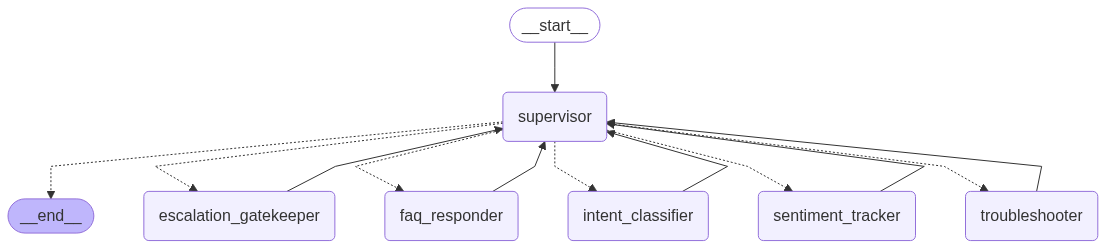

In [19]:
from IPython.display import Image, display

display(Image(customer_support_swarm.get_graph().draw_mermaid_png()))

In [28]:
# Example of a configuration object
config = {
    "configurable": {
        "thread_id": "2",
        "user_id": "1",
    }
}

# Example of invoking the workflow with a configuration object
result = customer_support_swarm.invoke({
    "messages": [
        {
            "role": "user",
            "content": "Thank you?"
        },
    ],
}, config=config)

for m in result["messages"]:
    m.pretty_print()

================================ Human Message =================================

How do I reset my password?
================================== Ai Message ==================================
Name: supervisor

I will route you to the `faq_responder` to answer your question about resetting your password.
Tool Calls:
  transfer_to_faq_responder (6dfcf6a8-e23e-4f9f-94bb-1d15cf81fc81)
 Call ID: 6dfcf6a8-e23e-4f9f-94bb-1d15cf81fc81
  Args:
================================= Tool Message =================================
Name: transfer_to_faq_responder

Successfully transferred to faq_responder
================================== Ai Message ==================================
Name: faq_responder

I couldn't find an answer in the FAQ for how to reset your password. This issue might require further assistance.
================================== Ai Message ==================================
Name: faq_responder

Transferring back to supervisor
Tool Calls:
  transfer_back_to_supervisor (39c76f23-9f33